# Library

In [1]:
!pip install torchsummary wandb segmentation_models_pytorch

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.6 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=c95c731073d973e888c77545123012e2f6ff02f4cdd16b223a02f2af2513ed52
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=d8d35f8a867ac4c0fd441d9cc06ae283f62b6accd2bf75cbebba00f04fdf2b7c
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficien

# Dataset preparation 

Augmentation including : rotation, flip, crop, resize, resample, normalization, elastic deformation

In [2]:
import numpy as np
import segmentation_models_pytorch as smp
import gc
import time
import wandb
import pandas as pd
import os
import cv2
import shutil
import matplotlib.pyplot as plt
from PIL import Image
import random
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torch.nn.functional as F
from torch import Tensor
from torchvision import models 
import torchvision.transforms as transforms
from torchvision.transforms import Resize, Compose, PILToTensor, InterpolationMode, ToPILImage
from torchvision import models
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torch.optim import lr_scheduler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.nn import init
from PIL import Image

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
class PolybDataset(Dataset):
    def __init__(self,root_dir, mask_dir, transform = None):
        self.root_dir = root_dir 
        self.mask_dir = mask_dir
        self.transform = transform
        self.data = []
        for img in os.listdir(root_dir):
            img_path = os.path.join(root_dir,img)
            mask_path = os.path.join(mask_dir, img)
            self.data.append((img_path,mask_path))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        img_path, mask_path = self.data[idx]
        img, mask = cv2.imread(img_path) , cv2.imread(mask_path)
        img,mask  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) , cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        #Resize
        img, mask = Image.fromarray(img) , Image.fromarray(mask)
        resize = transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.BILINEAR)
        to_tensor = transforms.PILToTensor()
        mask = to_tensor(mask)
        to_tensor = transforms.ToTensor()
        img = to_tensor(img)
        img = resize(img)
        mask = resize(mask)
    
        #Preprocess mask
        mask = mask / 255
        mask = torch.where(mask>0.65, 1.0, 0.0)
        mask[2, :, :] = 0.0001
        mask = torch.argmax(mask, 0).type(torch.int64)
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        # Normalize input img
        normalize = transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        img = normalize(img)
        
        return img,mask

In [5]:
train_dir = '/kaggle/input/bkai-igh-neopolyp/train/train'
train_gt_dir = '/kaggle/input/bkai-igh-neopolyp/train_gt/train_gt'

In [6]:
def visualize_segmentation(dataset):
    random_sample_ids = random.sample(range(len(dataset)), k=4)
    fig, ax = plt.subplots(4,2,figsize=(10, 10))
    for i in range (4):
        idx = random_sample_ids[i]
        image, mask = dataset[idx]
        image = image.permute(1, 2, 0).cpu().numpy()  
      
    
        ax[i,0].imshow(image)
        ax[i,0].set_title('Original Image')

        
        ax[i,1].imshow(mask)
        ax[i,1].set_title("Grouth Truth")
        
    plt.tight_layout()
    plt.show()

In [7]:
segmentation_dataset = PolybDataset(train_dir,train_gt_dir)

In [8]:
train_size = int(0.8 * len(segmentation_dataset))
val_size = len(segmentation_dataset) - train_size

In [9]:
# Set seed
torch.manual_seed(0)
train_dataset, val_dataset = random_split(segmentation_dataset, [train_size, val_size])

In [10]:
train_transforms = transforms.Compose([
    
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomHorizontalFlip(p=0.5),         
    transforms.RandomRotation(10),              
    #ransforms.RandomResizedCrop(size=(570,640)),  
])

val_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(size=(570,640))
])

In [11]:
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

In [12]:
train_loader = DataLoader(train_dataset, batch_size= 16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
len(train_dataset), len(val_dataset)

(800, 200)

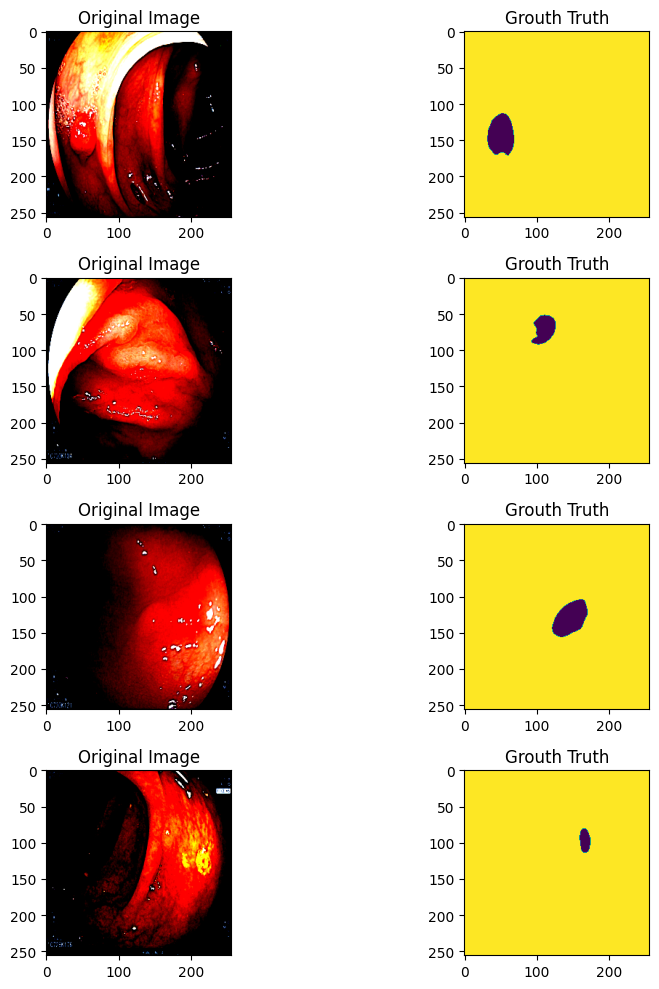

In [14]:
visualize_segmentation(train_dataset)

In [15]:
images, masks = next(iter(train_loader))
first_image , first_mask = images[0] , masks[0]
input_size = tuple(first_image.shape)
mask_size = tuple(first_mask.shape)
print(f"Input image size is {input_size}")
print(f"Mask image size is {mask_size}")

Input image size is (3, 256, 256)
Mask image size is (256, 256)


# Model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [17]:
# model = models.segmentation.deeplabv3_resnet50(pretrained=True)
# num_classes = 3 
# model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b5",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3     
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 224MB/s]


In [18]:
summary(model)

Layer (type:depth-idx)                                  Param #
UnetPlusPlus                                            --
├─EfficientNetEncoder: 1-1                              --
│    └─Conv2dStaticSamePadding: 2-1                     1,296
│    │    └─ZeroPad2d: 3-1                              --
│    └─BatchNorm2d: 2-2                                 96
│    └─ModuleList: 2-3                                  --
│    │    └─MBConvBlock: 3-2                            2,940
│    │    └─MBConvBlock: 3-3                            1,206
│    │    └─MBConvBlock: 3-4                            1,206
│    │    └─MBConvBlock: 3-5                            13,046
│    │    └─MBConvBlock: 3-6                            27,450
│    │    └─MBConvBlock: 3-7                            27,450
│    │    └─MBConvBlock: 3-8                            27,450
│    │    └─MBConvBlock: 3-9                            27,450
│    │    └─MBConvBlock: 3-10                           37,098
│    │    └─MBC

In [19]:
model.to(device)

UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

# Training

In [20]:
wandb.login(key="6ffb72fee22c0b5cc04049595683cc7bb0531a4d")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [21]:
os.makedirs('/kaggle/working/Model', exist_ok=True)

In [22]:
PROJECT = "Segmentation"
RESUME = "allow"
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
CHECKPOINT_PATH = '/kaggle/working/Model/best_check_point (1).pth'

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 20, gamma= 0.1)

In [24]:
wandb.init(

    project=PROJECT,

    resume=RESUME,

    config={

        "learning_rate": LEARNING_RATE,

        "epochs": NUM_EPOCHS,

        "batch_size": 16

    },

)

wandb.watch(model)

wandb: Currently logged in as: ducngoquang275 (ducngoquang275-hanoi-university-of-science-and-technology). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.18.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20241125_071832-bzoz5yrr
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fresh-sea-12
wandb: ⭐️ View project at https://wandb.ai/ducngoquang275-hanoi-university-of-science-and-technology/Segmentation
wandb: 🚀 View run at https://wandb.ai/ducngoquang275-hanoi-university-of-science-and-technology/Segmentation/runs/bzoz5yrr


[]

In [25]:
gc.collect()
torch.cuda.empty_cache()

In [26]:
best_val_loss = float('inf') 

for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()


    model.train()
    train_loss = 0
    train_accuracy = 0

    # Training loop
    for images, masks in train_loader:
        images = images.to(device).float()
        masks = masks.to(device=device, dtype=torch.long)

        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, masks)
        loss.backward()
        optimizer.step()

        # Update metrics
        train_loss += loss.item()


    train_loss /= len(train_loader.dataset)
    time_taken = time.time() - start_time

    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_loss = 0


    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device).float()
            masks = masks.to(device=device, dtype=torch.long)
            output = model(images)
            loss = loss_fn(output, masks)

            # Update metrics
            val_loss += loss.item()

    val_loss /= len(val_loader.dataset)


    # Log metrics
    print(
        f"Epoch {epoch}: "
        f"Train Loss: {train_loss:.4f} | "
        f"Validation Loss: {val_loss:.4f} | "
        f"Time taken: {time_taken:.4f}"
    )

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), CHECKPOINT_PATH)
        print("New best checkpoint saved!")

    wandb.log({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
    })

Epoch 1: Train Loss: 0.0342 | Validation Loss: 0.0067 | Time taken: 95.5505
New best checkpoint saved!
Epoch 2: Train Loss: 0.0060 | Validation Loss: 0.0034 | Time taken: 76.8233
New best checkpoint saved!
Epoch 3: Train Loss: 0.0037 | Validation Loss: 0.0031 | Time taken: 76.9253
New best checkpoint saved!
Epoch 4: Train Loss: 0.0028 | Validation Loss: 0.0023 | Time taken: 77.1243
New best checkpoint saved!
Epoch 5: Train Loss: 0.0023 | Validation Loss: 0.0026 | Time taken: 77.5968
Epoch 6: Train Loss: 0.0021 | Validation Loss: 0.0040 | Time taken: 78.0280
Epoch 7: Train Loss: 0.0020 | Validation Loss: 0.0025 | Time taken: 76.4014
Epoch 8: Train Loss: 0.0019 | Validation Loss: 0.0023 | Time taken: 85.5942
Epoch 9: Train Loss: 0.0014 | Validation Loss: 0.0028 | Time taken: 76.9108
Epoch 10: Train Loss: 0.0012 | Validation Loss: 0.0025 | Time taken: 76.9996
Epoch 11: Train Loss: 0.0011 | Validation Loss: 0.0023 | Time taken: 76.8033
New best checkpoint saved!
Epoch 12: Train Loss: 0.001

In [27]:
wandb.finish()

wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      epoch ▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
wandb: train_loss █▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   val_loss █▃▂▁▂▄▂▁▂▂▁▂▁▁▁▁▂▁▂▁▁▂▁▂▂▁▁▂▂▁
wandb: 
wandb: Run summary:
wandb:      epoch 30
wandb: train_loss 0.00034
wandb:   val_loss 0.00243
wandb: 
wandb: 🚀 View run fresh-sea-12 at: https://wandb.ai/ducngoquang275-hanoi-university-of-science-and-technology/Segmentation/runs/bzoz5yrr
wandb: ⭐️ View project at: https://wandb.ai/ducngoquang275-hanoi-university-of-science-and-technology/Segmentation
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20241125_071832-bzoz5yrr/logs
